# Context

The use of drones in increasingly diverse fields (logistics, surveillance, infrastructure
inspection, or even rescue operations) comes with growing challenges of reliability and
safety.
 Drone failures can lead to loss of equipment, service interruptions, or risks to
people.
 It is therefore essential to prevent breakdowns through preventive maintenanceand
early fault detectionapproaches, in order to intervene before an incident occurs or to
quickly identify its cause.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Objective

Based on the provided sensor data (in full or in part), the objective is to develop an
analysis and anomaly detection model capable of, depending on the chosen approach:</br>

 • Detecting the presence of a fault in the drone’s operation;</br>
 • Identifying the probable originof the fault;</br>
 • Assessing the severityof the detected fault to guide maintenance actions.</br>

 In short, the goal is to implement a predictive maintenanceapproach to improve the
availability, safety, and lifespan of drones.

# Loaing the data as watsonx

In [ ]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import re
import os

In [ ]:
def load_drone_data(path):
    data = loadmat(path)
    return data["commander_data"], data["QDrone_data"], data["stabilizer_data"]

In [ ]:
def extract_commander_data(commander):
    df = pd.DataFrame({
        "time": commander[0, :],
        "meas_x": commander[21, :],
        "meas_y": commander[22, :],
        "meas_z": commander[23, :],
        "meas_yaw": commander[24, :],
        "ref_x": commander[25, :],
        "ref_y": commander[26, :],
        "ref_z": commander[27, :],
        "ref_yaw": commander[28, :],
        "ref_thrust": commander[33, :],
        "ref_roll": commander[34, :],
        "ref_pitch": commander[35, :],
        "ref_yaw_rate": commander[36, :]
    })
    return df

In [ ]:
def extract_qdrone_data(qdrone):
    df = pd.DataFrame({
        "time": qdrone[0, :],
        # IMU 1 orientation
        "imu1_roll": qdrone[1, :],
        "imu1_pitch": qdrone[2, :],
        "imu1_yaw": qdrone[3, :],
        "imu1_roll_rate": qdrone[4, :],
        "imu1_pitch_rate": qdrone[5, :],
        "imu1_yaw_rate": qdrone[6, :],
        "imu1_roll_acc": qdrone[7, :],
        "imu1_pitch_acc": qdrone[8, :],
        "imu1_yaw_acc": qdrone[9, :],
        # IMU 2 orientation
        "imu2_roll": qdrone[10, :],
        "imu2_pitch": qdrone[11, :],
        "imu2_yaw": qdrone[12, :],
        "imu2_roll_rate": qdrone[13, :],
        "imu2_pitch_rate": qdrone[14, :],
        "imu2_yaw_rate": qdrone[15, :],
        "imu2_roll_acc": qdrone[16, :],
        "imu2_pitch_acc": qdrone[17, :],
        "imu2_yaw_acc": qdrone[18, :],
        # Other sensors
        "battery_level": qdrone[23, :],
        "gyro1_roll_rate": qdrone[26, :],
        "gyro1_pitch_rate": qdrone[27, :],
        "gyro1_yaw_rate": qdrone[28, :],
        "accel1_x": qdrone[29, :],
        "accel1_y": qdrone[30, :],
        "accel1_z": qdrone[31, :],
        "gyro2_roll_rate": qdrone[32, :],
        "gyro2_pitch_rate": qdrone[33, :],
        "gyro2_yaw_rate": qdrone[34, :],
        "accel2_x": qdrone[35, :],
        "accel2_y": qdrone[36, :],
        "accel2_z": qdrone[37, :],
        "height_range": qdrone[45, :],
        # Motor and ESC commands
        "front_left_motor_cmd": qdrone[46, :],
        "front_left_esc_cmd": qdrone[47, :],
        "front_right_motor_cmd": qdrone[48, :],
        "front_right_esc_cmd": qdrone[49, :],
        "back_left_motor_cmd": qdrone[50, :],
        "back_left_esc_cmd": qdrone[51, :],
        "back_right_motor_cmd": qdrone[52, :],
        "back_right_esc_cmd": qdrone[53, :]
    })
    return df

In [ ]:
def extract_stabilizer_data(stabilizer):
    df = pd.DataFrame({
        "time": stabilizer[0, :],
        "flight_mode": stabilizer[6, :]
    })
    return df

In [ ]:
def parse_filename(fname):
    match = re.match(r"F(\d+)_SV(\d+)_SP(\d+)_t(\d+)", fname)
    if match:
        F, SV, SP, t = map(int, match.groups())
        return F, SV, SP, t
    return None, None, None, None

In [ ]:
def process_file(file_path):
    fname = os.path.basename(file_path)
    F, SV, SP, t = parse_filename(fname)

    commander, qdrone, stabilizer = load_drone_data(file_path)

    df_commander = extract_commander_data(commander)
    df_qdrone = extract_qdrone_data(qdrone)
    df_stabilizer = extract_stabilizer_data(stabilizer)

    # Merge all on time (approx)
    df = df_commander.merge(df_qdrone, on="time", how="outer")
    df = df.merge(df_stabilizer, on="time", how="outer")

    # Add metadata columns
    df["fault_type"] = F
    df["severity"] = SV
    df["speed_level"] = SP
    df["trajectory"] = t
    return df

In [ ]:
if __name__ == "__main__":
    files = [
        "F0_SV0_SP1_t1_D1_R1.mat",
        "F1_SV1_SP1_t1.mat",
        "F1_SV2_SP1_t1.mat",
        "F1_SV3_SP1_t1.mat",
        "F2_SV1_SP1_t1.mat",
        "F2_SV2_SP1_t1.mat",
        "F2_SV3_SP1_t1.mat",
        "F3_SV1_SP1_t1.mat",
        "F3_SV2_SP1_t2.mat",
        "F3_SV3_SP1_t1.mat",
    ]

    all_df = []
    for f in files:
        df = process_file("/content/drive/MyDrive/"+f)
        all_df.append(df)

    combined = pd.concat(all_df, ignore_index=True)
    combined.to_csv("DronePropA_Full_Extraction.csv", index=False)
    print("Extraction complete → Saved as DronePropA_Full_Extraction.csv")

Extraction complete → Saved as DronePropA_Full_Extraction.csv


In [ ]:
data = pd.read_csv('DronePropA_Full_Extraction.csv')

# Data Exploration and Preparation

In [ ]:
data.head(10)

,time,meas_x,meas_y,meas_z,meas_yaw,ref_x,ref_y,ref_z,ref_yaw,ref_thrust,...,front_right_esc_cmd,back_left_motor_cmd,back_left_esc_cmd,back_right_motor_cmd,back_right_esc_cmd,flight_mode,fault_type,severity,speed_level,trajectory
0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.006299,0.0,0.006299,0.0,0.0,0,0,1,1
1,0.001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.002722,...,0.0,0.006303,0.0,0.006303,0.0,0.0,0,0,1,1
2,0.002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.005098,...,0.0,0.006289,0.0,0.006289,0.0,0.0,0,0,1,1
3,0.003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.007598,...,0.0,0.006303,0.0,0.006303,0.0,0.0,0,0,1,1
4,0.004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.009820,...,0.0,0.006303,0.0,0.006303,0.0,0.0,0,0,1,1
5,0.005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.012168,...,0.0,0.006299,0.0,0.006299,0.0,0.0,0,0,1,1
6,0.006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.014506,...,0.0,0.006303,0.0,0.006303,0.0,0.0,0,0,1,1
7,0.007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.016566,...,0.0,0.006310,0.0,0.006310,0.0,0.0,0,0,1,1
8,0.008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.018484,...,0.0,0.006296,0.0,0.006296,0.0,0.0,0,0,1,1
9,0.009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.020730,...,0.0,0.006303,0.0,0.006303,0.0,0.0,0,0,1,1


In [ ]:
data.isna().sum()

,0
time,0
meas_x,0
meas_y,0
meas_z,0
meas_yaw,0
ref_x,0
ref_y,0
ref_z,0
ref_yaw,0
ref_thrust,0


In [ ]:
data.shape[0]

883040

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883040 entries, 0 to 883039
Data columns (total 58 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   time                   883040 non-null  float64
 1   meas_x                 883040 non-null  float64
 2   meas_y                 883040 non-null  float64
 3   meas_z                 883040 non-null  float64
 4   meas_yaw               883040 non-null  float64
 5   ref_x                  883040 non-null  float64
 6   ref_y                  883040 non-null  float64
 7   ref_z                  883040 non-null  float64
 8   ref_yaw                883040 non-null  float64
 9   ref_thrust             883040 non-null  float64
 10  ref_roll               883040 non-null  float64
 11  ref_pitch              883040 non-null  float64
 12  ref_yaw_rate           883040 non-null  float64
 13  imu1_roll              883040 non-null  float64
 14  imu1_pitch             883040 non-nu

In [ ]:
data.describe()

,time,meas_x,meas_y,meas_z,meas_yaw,ref_x,ref_y,ref_z,ref_yaw,ref_thrust,...,front_right_esc_cmd,back_left_motor_cmd,back_left_esc_cmd,back_right_motor_cmd,back_right_esc_cmd,flight_mode,fault_type,severity,speed_level,trajectory
count,883040.000000,883040.000000,883040.000000,883040.000000,883040.000000,883040.000000,883040.000000,883040.000000,883040.000000,883040.000000,...,883040.000000,883040.000000,883040.000000,883040.000000,883040.000000,883040.0,883040.000000,883040.000000,883040.0,883040.000000
mean,44.240465,-0.252125,-0.056953,0.645002,-0.006619,-0.259819,-0.061083,0.634185,0.002644,-1.504551,...,0.498467,0.488593,0.511082,0.506794,0.514388,0.0,1.787048,1.790385,1.0,1.087856
std,25.636517,0.720501,0.748769,0.256309,0.017900,0.781015,0.816540,0.265464,0.009512,0.888540,...,0.126813,0.138337,0.129507,0.145206,0.134344,0.0,0.971577,0.980855,0.0,0.283085
min,0.000000,-1.045507,-1.050859,0.000000,-0.181803,-1.000000,-1.000000,0.000000,-0.009907,-13.531200,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0,1.000000
25%,22.076000,-0.950999,-0.923000,0.743798,-0.012756,-1.000000,-1.000000,0.750000,0.000000,-1.633126,...,0.524704,0.510223,0.536473,0.531499,0.542698,0.0,1.000000,1.000000,1.0,1.000000
50%,44.152000,-0.122487,-0.017230,0.750446,-0.008906,-0.078925,-0.017233,0.750000,0.000000,-1.464133,...,0.536161,0.527037,0.549082,0.548607,0.555414,0.0,2.000000,2.000000,1.0,1.000000
75%,66.228000,0.021557,0.804318,0.755642,-0.003987,0.017604,1.000000,0.750000,0.000000,-1.274935,...,0.548223,0.543915,0.562319,0.564527,0.567397,0.0,3.000000,3.000000,1.0,1.000000
max,93.216000,1.074151,1.052245,0.830222,0.063985,1.000000,1.000000,0.750000,0.044098,16.736858,...,0.644500,0.678987,0.655133,0.730932,0.663130,0.0,3.000000,3.000000,1.0,2.000000


# Feature Engineering

**Objective:** Transform raw drone signals into structured, interpretable metrics for analysis and fault
 detection.

## Position and Orientation Errors</br>



*   Compute deviation between measured and reference positions (X, Y, Z).
*   Compute yaw
 misalignment using wrapped angular difference.





In [ ]:
data["error_x"] = data["meas_x"] - data["ref_x"]
data["error_y"] = data["meas_y"] - data["ref_y"]
data["error_z"] = data["meas_z"] - data["ref_z"]
data["pos_error_norm"] = np.sqrt(data["error_x"]**2 + data["error_y"]**2 + data["error_z"]**2)

# Safe yaw difference (handles wrap-around)
data["yaw_error"] = np.arctan2(np.sin(data["meas_yaw"] - data["ref_yaw"]),
                               np.cos(data["meas_yaw"] - data["ref_yaw"]))

## Velocity and Acceleration



*   Derive drone velocity and acceleration by differentiating position over time.
*   Compute overall
 speed magnitude to capture motion intensity.



In [ ]:
data["dt"] = data["time"].diff().fillna(method="bfill")

# Velocity
data["vel_x"] = data["meas_x"].diff() / data["dt"]
data["vel_y"] = data["meas_y"].diff() / data["dt"]
data["vel_z"] = data["meas_z"].diff() / data["dt"]
data["speed"] = np.sqrt(data["vel_x"]**2 + data["vel_y"]**2 + data["vel_z"]**2)

# Acceleration
data["acc_x"] = data["vel_x"].diff() / data["dt"]
data["acc_y"] = data["vel_y"].diff() / data["dt"]
data["acc_z"] = data["vel_z"].diff() / data["dt"]
data["acc_mag"] = np.sqrt(data["acc_x"]**2 + data["acc_y"]**2 + data["acc_z"]**2)

/tmp/ipython-input-3524246221.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data["dt"] = data["time"].diff().fillna(method="bfill")


## Stability & Vibration Features


*   Use IMU signals (angular rates, accelerations) to quantify vibration levels.
*   High-frequency
 variations indicate propeller imbalance or structural fault.



In [ ]:
data["ang_vel_imu1"] = np.sqrt(
    data["imu1_roll_rate"]**2 + data["imu1_pitch_rate"]**2 + data["imu1_yaw_rate"]**2
)
data["ang_acc_imu1"] = np.sqrt(
    data["imu1_roll_acc"]**2 + data["imu1_pitch_acc"]**2 + data["imu1_yaw_acc"]**2
)
data["lin_acc_imu1"] = np.sqrt(
    data["accel1_x"]**2 + data["accel1_y"]**2 + data["accel1_z"]**2
)

## Actuator (Motor) Symmetry Features


*   Analyze motor command signals to detect imbalance between motors.
*   Compute mean, standard
 deviation, and asymmetry index across all four motors.



In [ ]:
motors = [
    "front_left_motor_cmd", "front_right_motor_cmd",
    "back_left_motor_cmd", "back_right_motor_cmd"
]

data["motor_mean"] = data[motors].mean(axis=1)
data["motor_std"] = data[motors].std(axis=1)
data["motor_asym"] = data["motor_std"] / (data["motor_mean"] + 1e-6)

## Energy / Power Proxy


*   Measure fluctuations in reference thrust as an indicator of control effort.
*    Smoother thrust profile implies stable dynamics.



In [ ]:
data["thrust_fluctuation"] = data["ref_thrust"].diff().abs()
data["thrust_smoothness"] = data["thrust_fluctuation"].rolling(10).mean()

## Statistical & Frequency Features


*   Aggregate per-flight metrics (mean, std, max, min) across each feature group.
*    Useful for ML model input representation.



In [ ]:
feature_cols = [
    "pos_error_norm", "yaw_error", "speed", "acc_mag",
    "ang_vel_imu1", "ang_acc_imu1", "lin_acc_imu1",
    "motor_asym", "motor_mean", "thrust_smoothness"
]

summary = data.groupby(["fault_type", "severity", "trajectory"]).agg({
    col: ["mean", "std", "max", "min"] for col in feature_cols
})
summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
summary = summary.reset_index()
summary.to_csv("DronePropA_Feature_Summary.csv", index=False)


## Feature Correlation Check


*   Compute correlation matrix across engineered features.
*   Identify redundant or highly correlated
 metrics before model training.



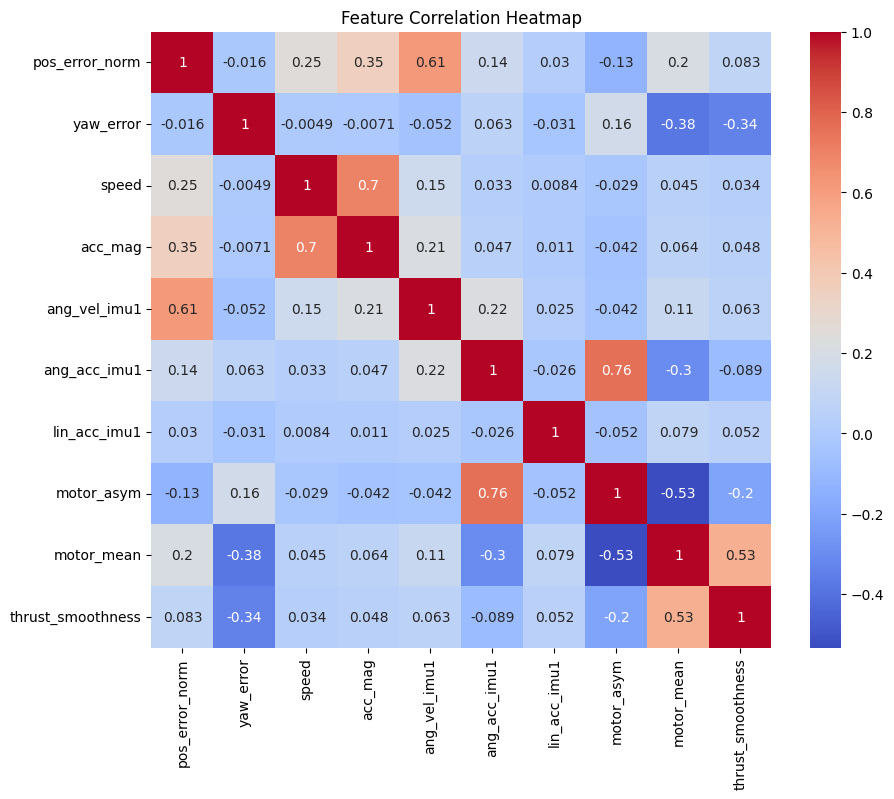

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = data[feature_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", annot=True)
plt.title("Feature Correlation Heatmap")
plt.show()

<Axes: xlabel='fault_type', ylabel='pos_error_norm'>

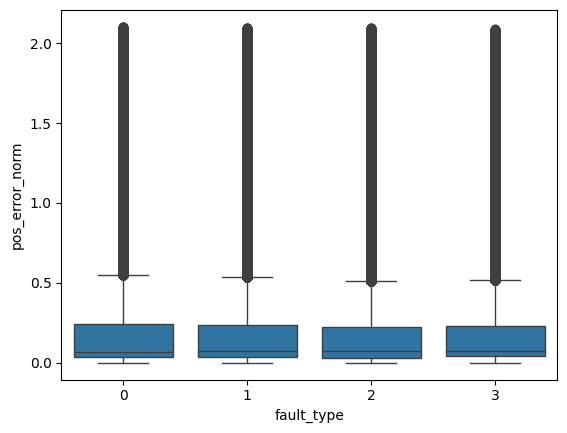

In [ ]:
import seaborn as sns
sns.boxplot(data=data, x="fault_type", y="pos_error_norm")

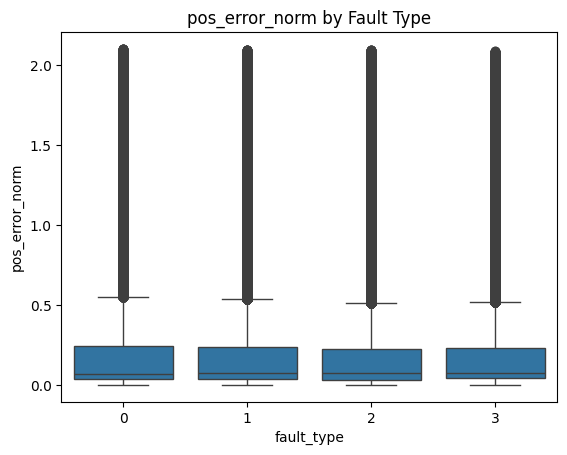

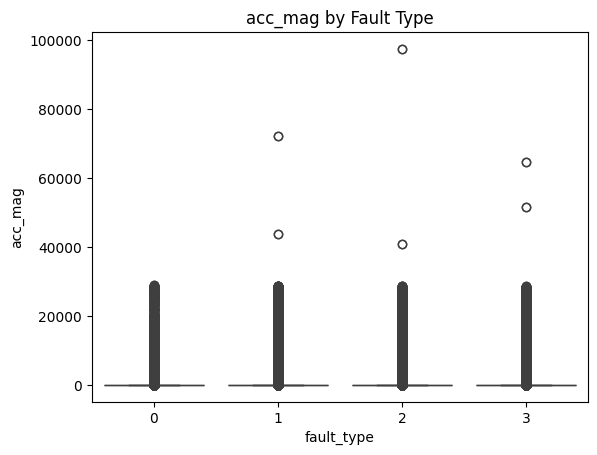

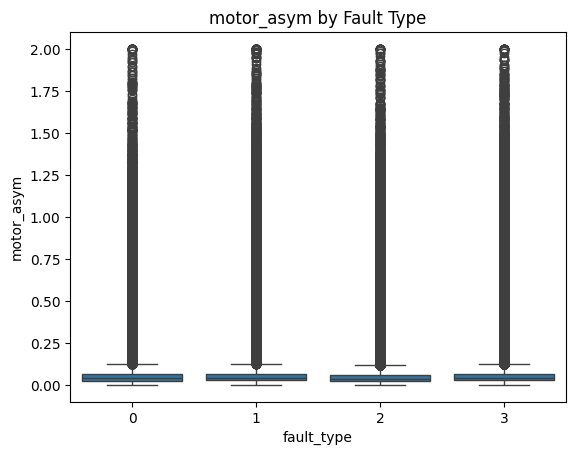

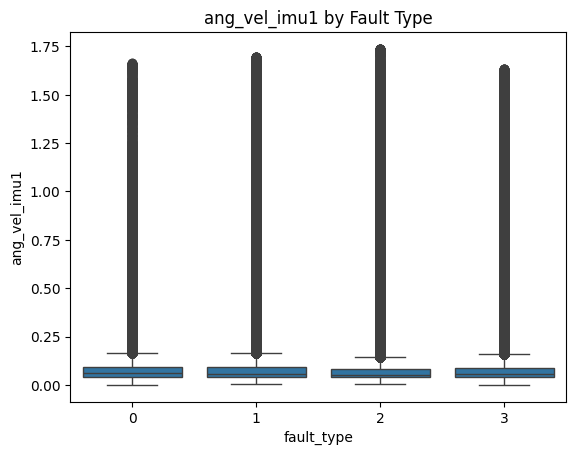

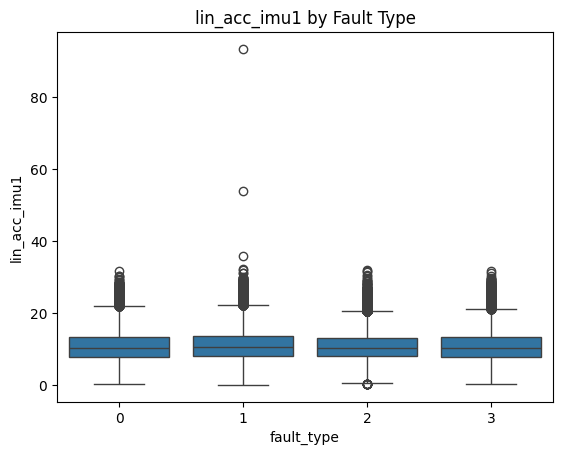

In [ ]:
features = ["pos_error_norm", "acc_mag", "motor_asym", "ang_vel_imu1", "lin_acc_imu1"]
for feat in features:
    sns.boxplot(data=data, x="fault_type", y=feat)
    plt.title(f"{feat} by Fault Type")
    plt.show()


<Axes: xlabel='pos_error_norm', ylabel='Density'>

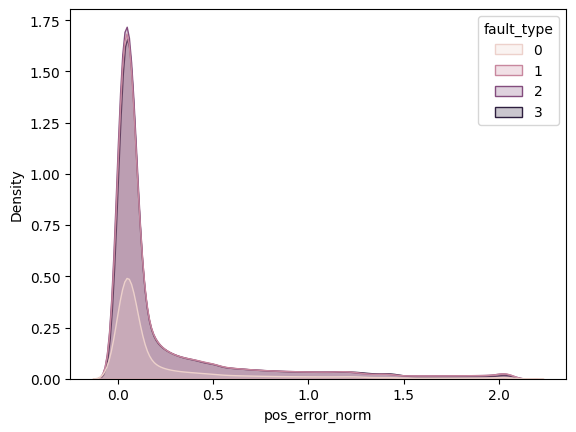

In [ ]:
sns.kdeplot(data=data, x="pos_error_norm", hue="fault_type", fill=True)

## Engineered Data
 Store final engineered features as DronePropA_FeatureEngineered.csv for modeling and
 analysis.

In [ ]:
data.to_csv("DronePropA_FeatureEngineered.csv", index=False)
print("Feature engineering complete → Saved as DronePropA_FeatureEngineered.csv")

Feature engineering complete → Saved as DronePropA_FeatureEngineered.csv


In [ ]:
df = pd.read_csv('/content/DronePropA_FeatureEngineered.csv')

# Normalization

In [ ]:
df.columns

Index(['time', 'meas_x', 'meas_y', 'meas_z', 'meas_yaw', 'ref_x', 'ref_y',
       'ref_z', 'ref_yaw', 'ref_thrust', 'ref_roll', 'ref_pitch',
       'ref_yaw_rate', 'imu1_roll', 'imu1_pitch', 'imu1_yaw', 'imu1_roll_rate',
       'imu1_pitch_rate', 'imu1_yaw_rate', 'imu1_roll_acc', 'imu1_pitch_acc',
       'imu1_yaw_acc', 'imu2_roll', 'imu2_pitch', 'imu2_yaw', 'imu2_roll_rate',
       'imu2_pitch_rate', 'imu2_yaw_rate', 'imu2_roll_acc', 'imu2_pitch_acc',
       'imu2_yaw_acc', 'battery_level', 'gyro1_roll_rate', 'gyro1_pitch_rate',
       'gyro1_yaw_rate', 'accel1_x', 'accel1_y', 'accel1_z', 'gyro2_roll_rate',
       'gyro2_pitch_rate', 'gyro2_yaw_rate', 'accel2_x', 'accel2_y',
       'accel2_z', 'height_range', 'front_left_motor_cmd',
       'front_left_esc_cmd', 'front_right_motor_cmd', 'front_right_esc_cmd',
       'back_left_motor_cmd', 'back_left_esc_cmd', 'back_right_motor_cmd',
       'back_right_esc_cmd', 'flight_mode', 'fault_type', 'severity',
       'speed_level', 'trajectory'

In [ ]:
num_features = [
    "pos_error_norm", "yaw_error", "speed", "acc_mag",
    "ang_vel_imu1", "ang_acc_imu1", "lin_acc_imu1",
    "motor_asym", "motor_mean", "ref_thrust", "thrust_smoothness"
]

In [ ]:
X = df[num_features].copy()
y = df[['fault_type', 'severity']]
groups = df["trajectory"]

In [ ]:
std_features = ["pos_error_norm", "speed", "acc_mag", "ang_vel_imu1", "ang_acc_imu1", "lin_acc_imu1"]
mm_features  = ["motor_asym", "motor_mean", "ref_thrust", "thrust_smoothness"]

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler_std = StandardScaler()
scaler_mm = MinMaxScaler()

X[std_features] = scaler_std.fit_transform(X[std_features])
X[mm_features]  = scaler_mm.fit_transform(X[mm_features])

In [ ]:
X["yaw_error"] = X["yaw_error"] / np.pi

Group-based train/test split

In [ ]:

from sklearn.model_selection import GroupShuffleSplit

splitter = GroupShuffleSplit(test_size=0.3, n_splits=1, random_state=42)
for train_idx, test_idx in splitter.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

Train Random Forest model

In [ ]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=5,
    random_state=42
)
clf.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=5, random_state=42)

In [ ]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)

for i, col in enumerate(y_test.columns):
    print(f"\n=== Rapport pour {col} ===")
    print(classification_report(y_test.iloc[:, i], y_pred[:, i], zero_division=0))



=== Rapport pour fault_type ===
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     26351
           1       0.87      1.00      0.93     80193
           2       0.93      1.00      0.96     81886
           3       1.00      0.74      0.85     76482

    accuracy                           0.93    264912
   macro avg       0.94      0.94      0.93    264912
weighted avg       0.93      0.93      0.92    264912


=== Rapport pour severity ===
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     26351
           1       0.85      1.00      0.92     81963
           2       1.00      0.73      0.84     77461
           3       0.93      1.00      0.96     79137

    accuracy                           0.92    264912
   macro avg       0.93      0.93      0.93    264912
weighted avg       0.93      0.92      0.92    264912

